In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
from model import *
from utils import *

In [2]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)

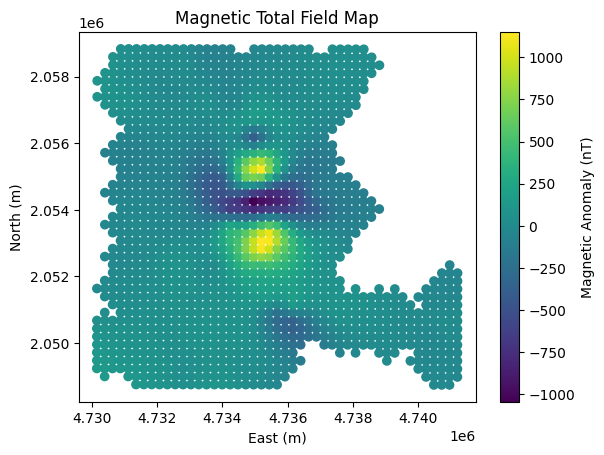

In [3]:
# Scatter plot of magnetic anomaly
plt.scatter(df_magnetometry["Este"], df_magnetometry["Norte"], c=df_magnetometry["Anomalia_Magnetica_Campo_Total"], cmap="viridis")
plt.colorbar(label="Magnetic Anomaly (nT)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Magnetic Total Field Map")
plt.show()

In [4]:
# Coordinates and values
x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

grid_x_magn1, grid_y_magn1 = np.mgrid[x_magn.min():x_magn.max():200j, y_magn.min():y_magn.max():200j]

In [5]:
# numpy matrix
coords_magn = np.stack([x_magn, y_magn], axis=1).astype(np.float32)   # [M, 2]
targets_magn = z_magn.astype(np.float32).reshape(-1, 1)               # [M, 1]

coords_magn_min = np.stack([np.min(x_magn), np.min(y_magn)], axis=0).astype(np.float32) 
coords_magn_max = np.stack([np.max(x_magn), np.max(y_magn)], axis=0).astype(np.float32)

targets_magn_max = np.max(targets_magn)   
targets_magn_min = np.min(targets_magn)   


Xm_n = (coords_magn[:,0]-coords_magn_min[0])/(coords_magn_max[0]-coords_magn_min[0])
Ym_n = (coords_magn[:,1]-coords_magn_min[1])/(coords_magn_max[1]-coords_magn_min[1])


coords_magn_norm = np.stack([Xm_n, Ym_n], axis=1).astype(np.float32)

# DataLoaders
ds_magn = TensorDataset(torch.from_numpy(coords_magn_norm), torch.from_numpy(targets_magn))

dl_magn = DataLoader(ds_magn, batch_size=256, shuffle=True)

In [6]:
#Split dataloader
batch_size = 256
train_magn, val_magn = train_val_split(ds_magn, val_ratio=0.2)

dl_magn_train = DataLoader(train_magn, batch_size=batch_size, shuffle=True, num_workers=0)
dl_magn_val   = DataLoader(val_magn,   batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
###### Training
activation = "sine"
input_transform = "FF"
num_layers = 15
num_neurons = 128

if activation == "wire":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=num_layers, hidden_units=num_neurons,
        activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
    )

if activation == "sine":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=num_layers, hidden_units=num_neurons,
        activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
    )

if activation == "relu":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=num_layers, hidden_units=num_neurons,
        activation=activation, input_transform=input_transform  # synthetic-like defaults
    )

epochs = 5000

lr = 1e-4
max_lr = 2e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_magn),
    epochs=epochs
)

loss = []

In [ ]:
for epoch in range(epochs):
    for batch_magn in dl_magn_train:
        optimizer.zero_grad()
        coords_magn, target_magn = batch_magn
        pred_magn = model(coords_magn)
        pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

        loss = criterion(pred_magn_denorm,target_magn)
        loss.backward()
        optimizer.step()
        scheduler.step()

    if (epoch + 1) % 100 == 0:
        torch.save(model.state_dict(), f'checkpoints/2magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth')

    print("Epoch: ", epoch, " Loss: ", loss.item())      

Epoch:  0  Loss:  710407.0
Epoch:  1  Loss:  289939.78125
Epoch:  2  Loss:  91698.625
Epoch:  3  Loss:  42551.6640625
Epoch:  4  Loss:  63421.6484375
Epoch:  5  Loss:  122919.9765625
Epoch:  6  Loss:  138486.546875
Epoch:  7  Loss:  121005.1484375
Epoch:  8  Loss:  73259.8515625
Epoch:  9  Loss:  60559.1640625
Epoch:  10  Loss:  49862.1640625
Epoch:  11  Loss:  42954.75
Epoch:  12  Loss:  47706.66796875
Epoch:  13  Loss:  66267.6484375
Epoch:  14  Loss:  52579.4140625
Epoch:  15  Loss:  40086.54296875
Epoch:  16  Loss:  22082.73828125
Epoch:  17  Loss:  47435.5859375
Epoch:  18  Loss:  53593.6015625
Epoch:  19  Loss:  42262.890625
Epoch:  20  Loss:  30100.85546875
Epoch:  21  Loss:  27305.4140625
Epoch:  22  Loss:  51945.4609375
Epoch:  23  Loss:  21613.24609375
Epoch:  24  Loss:  51735.7578125
Epoch:  25  Loss:  34787.765625
Epoch:  26  Loss:  47188.64453125
Epoch:  27  Loss:  50665.703125
Epoch:  28  Loss:  25918.126953125
Epoch:  29  Loss:  53037.3125
Epoch:  30  Loss:  54245.957031

In [ ]:
activation = "sine"

if activation == "wire":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=num_layers, hidden_units=num_neurons,
        activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
    )
    model.load_state_dict(torch.load(f"checkpoints/magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()

if activation == "sine":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=num_layers, hidden_units=num_neurons,
        activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
    )
    model.load_state_dict(torch.load(f"checkpoints/magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()

if activation == "relu":
    model = CMLP(
        in_features=2, out_features=1,
        hidden_layers=num_layers, hidden_units=num_neurons,
        activation=activation, input_transform=input_transform  # synthetic-like defaults        
    )
    model.load_state_dict(torch.load(f"checkpoints/magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()


for batch_magn in dl_magn_val:
    coords_magn, target_magn = batch_magn

    pred_magn = model(coords_magn)
    pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

    coords_magn_denorm = denorm_torch(coords_magn, coords_magn_min, coords_magn_max)

    print("Coords: ", coords_magn_denorm[0], " Target: ", target_magn[2].item(), " Prediction: ", pred_magn_denorm[2].item())
    print("MSE: ", criterion(pred_magn_denorm,target_magn).item())
    break

Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  66.681396484375
MSE:  457.57025146484375


In [ ]:
######  agregar code inferencia

#### Relu
###Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  66.681396484375
###MSE:  457.57025146484375


#### Sine
###Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  36.4681396484375
###MSE:  218.6893768310547

#### Wire
###Coords:  tensor([4741198., 2049699.])  Target:  46.991920471191406  Prediction:  35.3487548828125
###MSE:  221.7586669921875